In [1]:
# %pip install pandas
# %pip install matplotlib
# %pip install tqdm

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib
import tqdm.auto as tqdm

In [3]:
class MABEnv:
    def __init__(self, num_actions: int):
        self.num_actions = num_actions
        self.actions = np.ndarray(num_actions)
        self.reset()
        
    def reset(self):
        self.rewards = np.random.standard_normal(size=self.num_actions)

    def get_actions(self) -> np.ndarray:
        return self.actions

    def get_rewards(self) -> np.ndarray:
        return self.rewards

    def perform_action(self, action_id: int, size=1) -> float:
        return np.random.normal(loc=self.rewards[action_id], scale=1, size=size)[0]

In [4]:
class DummyEstimator:
    def __init__(self, env):
        self.reward_estimates = np.full_like(env.get_actions(), fill_value=1)

    def reset(self):
        pass

    def learn_reward(self, action_id: int, reward: float) -> None:
        pass
    
    def get_rewards(self) -> np.ndarray:
        return self.reward_estimates

In [5]:
class OracleEstimator:
    def __init__(self, env):
        self.env = env

    def reset(self):
        pass

    def learn_reward(self, action_id: int, reward: float) -> None:
        pass
    
    def get_rewards(self) -> np.ndarray:
        return self.env.get_rewards()

In [6]:
class RunningMeanEstimator:
    def __init__(self, env):
        self.env = env
        self.reset()

    def reset(self):
        self.reward_counts = np.full_like(self.env.get_actions(), fill_value=0)
        self.reward_estimates = np.full_like(self.env.get_actions(), fill_value=0)

    def learn_reward(self, action_id: int, reward: float) -> None:
        self.reward_counts[action_id] += 1
        self.reward_estimates[action_id] += (reward - self.reward_estimates[action_id]) / self.reward_counts[action_id]

    def get_rewards(self) -> np.ndarray:
        return self.reward_estimates

In [7]:
class OptimisticRunningMeanEstimator:
    def __init__(self, env, initial_reward=5):
        self.env = env
        self.initial_reward = initial_reward
        self.reset()

    def reset(self):
        self.reward_counts = np.full_like(self.env.get_actions(), fill_value=0)
        self.reward_estimates = np.full_like(self.env.get_actions(), fill_value=self.initial_reward)

    def learn_reward(self, action_id: int, reward: float) -> None:
        self.reward_counts[action_id] += 1
        self.reward_estimates[action_id] += (reward - self.reward_estimates[action_id]) / self.reward_counts[action_id]

    def get_rewards(self) -> np.ndarray:
        return self.reward_estimates

In [8]:
class RandomSelectionRule:
    def pick_action(self, env, estimator):
        return random.randint(0, len(estimator.get_rewards())-1)

In [9]:
class GreedySelectionRule:
    def pick_action(self, env, estimator):
        return estimator.get_rewards().argmax()

In [10]:
class EpsilonGreedySelectionRule:
    def __init__(self, eps: float = 0.1):
        self.eps = eps

    def pick_action(self, env, estimator):
        if random.random() >= self.eps:
            return estimator.get_rewards().argmax()
        else:
            return random.randint(0, len(env.get_rewards())-1)

In [19]:
def simulate(env, estimator, rule, steps):
    estimator.reset()
    rewards = []
    picked_actions = []
    optimal_actions = []
    for step in range(steps):
        action_id = rule.pick_action(env, estimator)
        reward = env.perform_action(action_id)
        estimator.learn_reward(action_id, reward)
        rewards.append(reward)
        picked_actions.append(action_id)
        optimal_actions.append(env.get_rewards().argmax())
    
    rewards = np.array(rewards)
    rewards = rewards.cumsum() / np.arange(1, len(rewards)+1)
    picked_actions = np.array(picked_actions)
    optimal_actions = np.array(optimal_actions)
    optimal_ratios = (picked_actions == optimal_actions).astype(int).cumsum() / np.arange(1, len(rewards)+1)

    result = {
        "step": np.arange(1, steps+1),
        "rewards": rewards,
        "optimal": optimal_ratios
    }
    return pd.DataFrame(result).set_index("step")

In [20]:
env = MABEnv(num_actions=10)

In [21]:
env.reset()
print(env.get_rewards())

[ 0.35004912  1.33680456 -0.7993025   0.60709551  0.60476109 -2.43135082
 -1.49194262 -1.13420501  0.60760345 -1.21301043]


In [22]:
pd.DataFrame(simulate(env, DummyEstimator(env), RandomSelectionRule(), steps=1000))

,rewards,optimal
step,,
1,-1.350764,0.000000
2,0.881961,0.500000
3,-0.471007,0.333333
4,-0.143636,0.250000
5,-0.107249,0.200000
...,...,...
996,-0.374117,0.092369
997,-0.373831,0.092277
998,-0.374592,0.092184


<Axes: xlabel='step'>

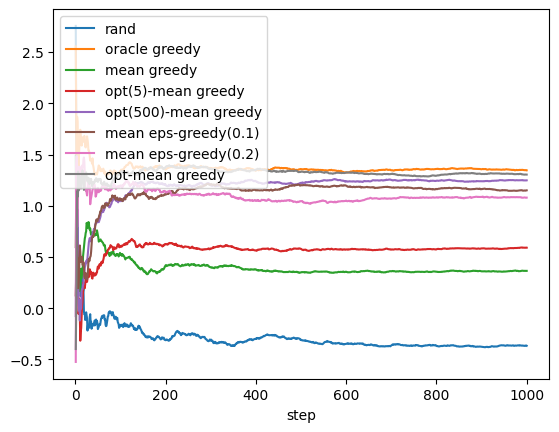

In [24]:
pd.DataFrame({
    'rand': simulate(env, DummyEstimator(env), RandomSelectionRule(), steps=1000)["rewards"],
    'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=1000)["rewards"],
    'mean greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=1000)["rewards"],
    'opt(5)-mean greedy': simulate(env, OptimisticRunningMeanEstimator(env, 5), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["rewards"],
    'opt(500)-mean greedy': simulate(env, OptimisticRunningMeanEstimator(env, 500), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["rewards"],
    'mean eps-greedy(0.1)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.1), steps=1000)["rewards"],
    'mean eps-greedy(0.2)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.2), steps=1000)["rewards"],
    'opt-mean greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["rewards"],
}).plot()

<Axes: xlabel='step'>

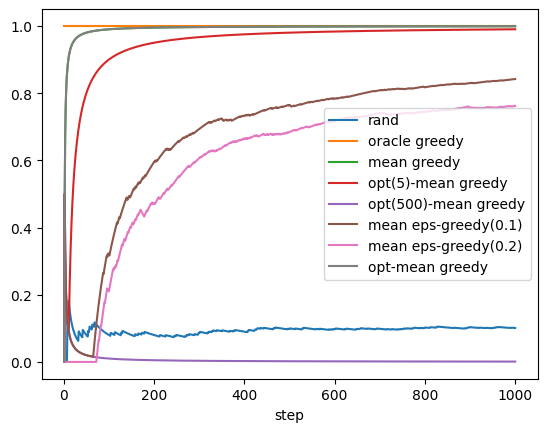

In [25]:
pd.DataFrame({
    'rand': simulate(env, DummyEstimator(env), RandomSelectionRule(), steps=1000)["optimal"],
    'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=1000)["optimal"],
    'mean greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=1000)["optimal"],
    'opt(5)-mean greedy': simulate(env, OptimisticRunningMeanEstimator(env, 5), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["optimal"],
    'opt(500)-mean greedy': simulate(env, OptimisticRunningMeanEstimator(env, 500), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["optimal"],
    'mean eps-greedy(0.1)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.1), steps=1000)["optimal"],
    'mean eps-greedy(0.2)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.2), steps=1000)["optimal"],
    'opt-mean greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["optimal"],
}).plot()

In [127]:
env.reset()
print(env.get_rewards())

[ 0.51253383 -0.63105992 -0.41457106  0.87839811 -0.15225975  0.98194246
 -0.30672961 -1.04114005  1.34309603  0.44396839]


  0%|          | 0/2000 [00:00<?, ?it/s]

<Axes: xlabel='step', ylabel='average reward'>

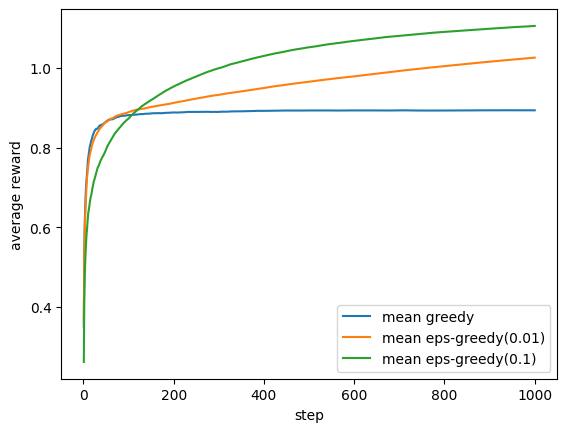

In [30]:
run_traces = []
for run_id in tqdm.trange(2000, leave=False):
    run_trace = pd.DataFrame({
        # 'rand': simulate(env, DummyEstimator(env), RandomSelectionRule(), steps=1000)["rewards"],
        # 'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=1000)["rewards"],
        'mean greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=1000)["rewards"],
        # 'opt(0)-mean greedy': simulate(env, OptimisticRunningMeanEstimator(env, 0), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["rewards"],
        # 'opt(5)-mean greedy': simulate(env, OptimisticRunningMeanEstimator(env, 5), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["rewards"],
        'mean eps-greedy(0.01)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.01), steps=1000)["rewards"],
        'mean eps-greedy(0.1)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.1), steps=1000)["rewards"],
        # 'mean eps-greedy(0.2)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.2), steps=1000)["rewards"]
    })
    run_trace = run_trace.reset_index().rename(columns={"index": "step"})
    run_trace["run_id"] = run_id
    run_traces.append(run_trace)
pd.concat(run_traces).groupby("step").mean().drop(columns=["run_id"]).plot(ylabel="average reward")

  0%|          | 0/2000 [00:00<?, ?it/s]

<Axes: xlabel='step', ylabel='optimal action rate'>

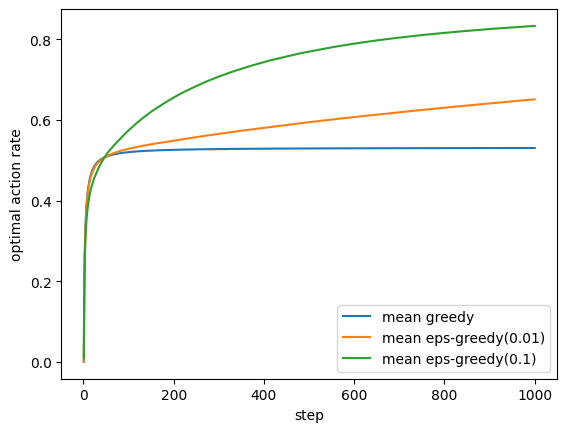

In [29]:
run_traces = []
for run_id in tqdm.trange(2000, leave=False):
    run_trace = pd.DataFrame({
        # 'rand': simulate(env, DummyEstimator(env), RandomSelectionRule(), steps=1000)["optimal"],
        # 'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=1000)["optimal"],
        'mean greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=1000)["optimal"],
        # 'opt(0)-mean greedy': simulate(env, OptimisticRunningMeanEstimator(env, 0), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["optimal"],
        # 'opt(5)-mean greedy': simulate(env, OptimisticRunningMeanEstimator(env, 5), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["optimal"],
        'mean eps-greedy(0.01)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.01), steps=1000)["optimal"],
        'mean eps-greedy(0.1)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.1), steps=1000)["optimal"],
        # 'mean eps-greedy(0.2)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.2), steps=1000)["optimal"]
    })
    run_trace = run_trace.reset_index().rename(columns={"index": "step"})
    run_trace["run_id"] = run_id
    run_traces.append(run_trace)
pd.concat(run_traces).groupby("step").mean().drop(columns=["run_id"]).plot(ylabel="optimal action rate")

  0%|          | 0/2000 [00:00<?, ?it/s]

<Axes: xlabel='step', ylabel='average reward'>

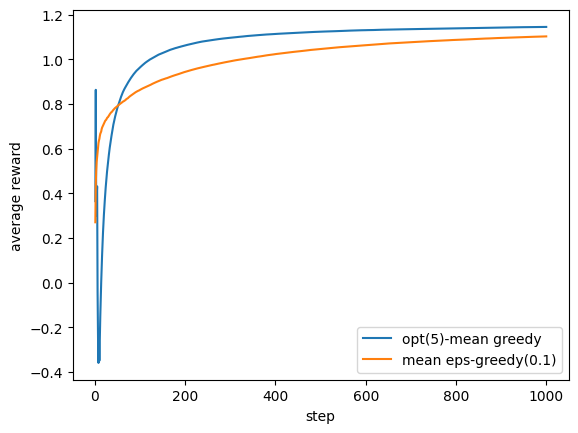

In [32]:
run_traces = []
for run_id in tqdm.trange(2000, leave=False):
    run_trace = pd.DataFrame({
        'opt(5)-mean greedy': simulate(env, OptimisticRunningMeanEstimator(env, 5), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["rewards"],
        'mean eps-greedy(0.1)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.1), steps=1000)["rewards"],
    })
    run_trace = run_trace.reset_index().rename(columns={"index": "step"})
    run_trace["run_id"] = run_id
    run_traces.append(run_trace)
pd.concat(run_traces).groupby("step").mean().drop(columns=["run_id"]).plot(ylabel="average reward")

  0%|          | 0/2000 [00:00<?, ?it/s]

<Axes: xlabel='step', ylabel='optimal action rate'>

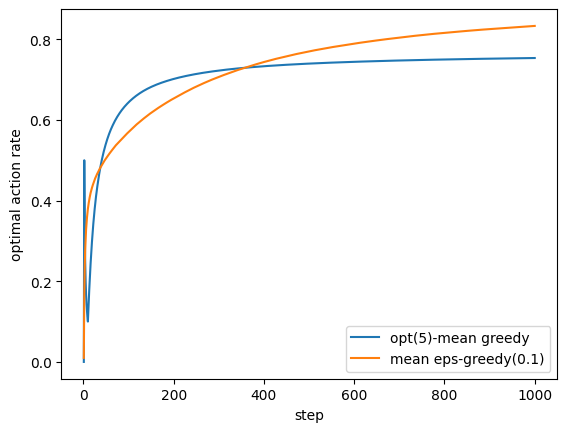

In [35]:
run_traces = []
for run_id in tqdm.trange(2000, leave=False):
    run_trace = pd.DataFrame({
        'opt(5)-mean greedy': simulate(env, OptimisticRunningMeanEstimator(env, 5), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["optimal"],
        'mean eps-greedy(0.1)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.1), steps=1000)["optimal"]
    })
    run_trace = run_trace.reset_index().rename(columns={"index": "step"})
    run_trace["run_id"] = run_id
    run_traces.append(run_trace)
pd.concat(run_traces).groupby("step").mean().drop(columns=["run_id"]).plot(ylabel="optimal action rate")